=== A1: Units demonstration ===
Summation unit (first AND input) -> 10.0
Step activation(s0) -> 1
Comparator for target 0 and output 1 -> [-1]

=== A2: Perceptron train on AND (step activation) ===
Final weights: [-0.05  0.05  0.05]
Epochs taken: 130
Last SSE: 0.0


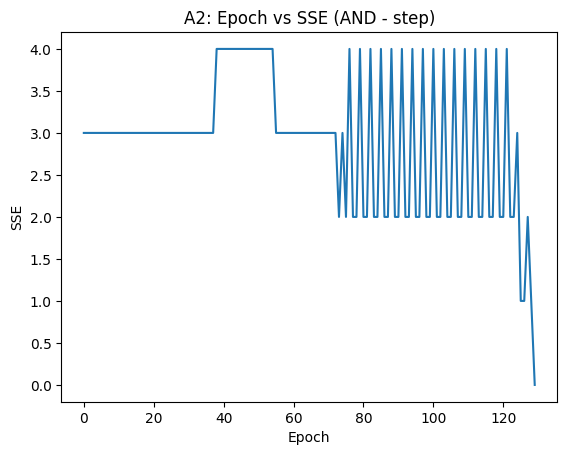

=== A3: Compare activations for AND ===
Activation: step -> epochs: 130, final SSE: 0.0
Activation: bipolar -> epochs: 500, final SSE: 3.0
Activation: sigmoid -> epochs: 130, final SSE: 0.0
Activation: relu -> epochs: 130, final SSE: 0.0

=== A4: Vary learning rates (AND) ===
lr=0.1 -> epochs=69
lr=0.2 -> epochs=38
lr=0.3 -> epochs=29
lr=0.4 -> epochs=25
lr=0.5 -> epochs=19
lr=0.6 -> epochs=20
lr=0.7 -> epochs=15
lr=0.8 -> epochs=14
lr=0.9 -> epochs=14
lr=1.0 -> epochs=13


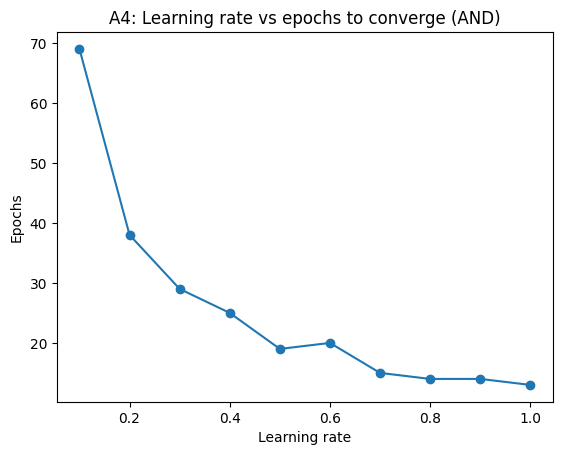

=== A5: XOR with single perceptron (expected to fail) ===
XOR perceptron epochs: 1000 last SSE: 2.0

=== A6: Customer data perceptron (sigmoid) ===
Customer perceptron final weights: [-0.1        -0.025       0.21       -0.075       0.18533569]
Classification report (train):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         6

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10


=== A7: Pseudo-inverse solution (customer data) ===
Pseudo-inverse weights: [ 0.10693353 -0.30835084  0.67960257 -0.01429023  0.64216914]
PI classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         6

    accuracy                           1.00        10
   macro avg

D:\OS\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\asus\AppData\Local\Temp\ipykernel_7468\2394468928.py:59: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(ann)


Project dataset sizes -> train: (34, 6) test: (12, 6) unique labels: [2 4]
Project dataset classification report (A12):
              precision    recall  f1-score   support

           2     0.9000    0.9000    0.9000        10
           4     0.5000    0.5000    0.5000         2

    accuracy                         0.8333        12
   macro avg     0.7000    0.7000    0.7000        12
weighted avg     0.8333    0.8333    0.8333        12



In [2]:


import os
from collections import Counter
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt
from math import exp
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from numpy.linalg import pinv

# ---------------------------
# USER SETTINGS (edit as needed)
# ---------------------------
DATA_PATH = r"C:\Users\asus\Downloads\sleep-edf-database-expanded-1.0.0"
CROP_SECONDS = None           # None = full recording; set small value to speed tests
PREFERRED_CHANNELS = ["EEG Fpz-Cz", "Fpz-Cz", "EEG Pz-Oz", "Pz-Oz"]
MAX_FILES_SEARCH = 5          # how many PSG files to probe while looking for usable epochs
RANDOM_STATE = 42

# ---------------------------
# Utility: Load PSG + extract simple epoch features (no prints here)
# ---------------------------
def find_first_usable_file(data_path, max_files=MAX_FILES_SEARCH, keep_stages=(2,4)):
    """Search dataset for first PSG file that has epochs for keep_stages (N2, REM)."""
    count = 0
    for root, _, files in os.walk(data_path):
        for f in files:
            if f.endswith("-PSG.edf"):
                psg = os.path.join(root, f)
                hyp = None
                for g in files:
                    if "hyp" in g.lower():
                        hyp = os.path.join(root, g); break
                df = load_epochs_from_file(psg, hyp, keep_stages=keep_stages, max_epochs=200)
                count += 1
                if df is not None and df.shape[0] > 0:
                    return psg, hyp, df
                if max_files and count >= max_files:
                    break
    return None, None, pd.DataFrame()

def load_epochs_from_file(psg_file, hyp_file=None, keep_stages=(2,4), epoch_sec=30, max_epochs=None):
    """Load EDF, pick channel, and extract simple time-domain features per epoch.
       Returns DataFrame with columns: mean,std,min,max,p25,p75,stage (numeric stage codes).
       If keep_stages is None, extracts all stages present (mapped to numbers)."""
    try:
        raw = mne.io.read_raw_edf(psg_file, preload=True, stim_channel=None, verbose="ERROR")
    except Exception:
        return None
    if CROP_SECONDS:
        raw.crop(tmin=0, tmax=CROP_SECONDS)
    if hyp_file and os.path.exists(hyp_file):
        ann = mne.read_annotations(hyp_file)
        raw.set_annotations(ann)
    # choose preferred channel if available
    ch_found = None
    for p in PREFERRED_CHANNELS:
        if p in raw.ch_names:
            raw.pick_channels([p]); ch_found = p; break
    if ch_found is None:
        raw.pick_channels([raw.ch_names[0]]); ch_found = raw.ch_names[0]
    sfreq = int(raw.info['sfreq'])
    sig = raw.get_data()[0]
    # mapping found in Sleep-EDF hypnograms
    mapping = {
        "Sleep stage W": 0, "W": 0, "0":0,
        "Sleep stage 1": 1, "1":1,
        "Sleep stage 2": 2, "2":2,
        "Sleep stage 3": 3, "3":3,
        "Sleep stage 4": 3, "4":3,
        "Sleep stage R": 4, "R":4
    }
    feats, labs = [], []
    for i, ann in enumerate(raw.annotations):
        if max_epochs and i >= max_epochs:
            break
        desc = ann['description']
        # some files use numeric descriptions
        lab = mapping.get(desc, None)
        if lab is None:
            # try to parse numbers inside desc
            try:
                lab = int(''.join([c for c in str(desc) if c.isdigit()])) if any(c.isdigit() for c in str(desc)) else None
            except:
                lab = None
        if lab is None:
            continue
        if keep_stages and lab not in keep_stages:
            continue
        start = int(ann['onset'] * sfreq)
        end = start + epoch_sec * sfreq
        if end > len(sig):
            continue
        segment = sig[start:end]
        feats.append([segment.mean(), segment.std(), segment.min(), segment.max(),
                      np.percentile(segment,25), np.percentile(segment,75)])
        labs.append(int(lab))
    if len(feats) == 0:
        return pd.DataFrame()
    df = pd.DataFrame(feats, columns=['mean','std','min','max','p25','p75'])
    df['stage'] = labs
    return df

# ---------------------------
# === A1: Summation, Activation, Comparator units ===
# ---------------------------
def summation_unit(weights, inputs):
    """w0 is bias term at index 0. inputs must include bias input 1 at index 0."""
    return np.dot(weights, inputs)

# Activation functions (return scalar or numpy array)
def act_step(x):
    return np.where(x >= 0.0, 1, 0)

def act_bipolar_step(x):
    return np.where(x >= 0.0, 1, -1)

def act_sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def act_tanh(x):
    return np.tanh(x)

def act_relu(x):
    return np.maximum(0, x)

def act_leaky_relu(x, alpha=0.01):
    return np.where(x >= 0, x, alpha * x)

def comparator_unit(targets, outputs):
    """Return error vector (targets - outputs)."""
    return np.array(targets) - np.array(outputs)

# ---------------------------
# === A2: Perceptron training (from scratch) ===
# ---------------------------
def perceptron_train(X, y, weights_init, lr=0.05, activation='step', max_epochs=1000, tol=0.002):
    """Train a single-layer perceptron using specified activation ('step','bipolar','sigmoid','relu').
       X should NOT include bias column; this function will add bias feature = 1.
       weights_init length must be n_features+1"""
    Xb = np.hstack([np.ones((X.shape[0],1)), X])  # bias column
    w = np.array(weights_init, dtype=float).copy()
    epoch_errors = []
    for epoch in range(1, max_epochs+1):
        outputs = []
        for xi in Xb:
            s = summation_unit(w, xi)
            if activation == 'step':
                out = act_step(s)
            elif activation == 'bipolar':
                out = act_bipolar_step(s)
            elif activation == 'sigmoid':
                out = act_sigmoid(s)
                out = 1 if out >= 0.5 else 0
            elif activation == 'relu':
                out = act_relu(s); out = 1 if out > 0 else 0
            else:
                out = act_step(s)
            outputs.append(out)
        err = comparator_unit(y, outputs)
        sse = np.sum(err.astype(float)**2)
        epoch_errors.append(sse)
        # weight update (perceptron learning rule) — for step-like outputs
        for i, xi in enumerate(Xb):
            w += lr * (y[i] - outputs[i]) * xi
        if sse <= tol:
            break
    return w, epoch_errors, epoch

def perceptron_predict(X, w, activation='step'):
    Xb = np.hstack([np.ones((X.shape[0],1)), X])
    outs = []
    for xi in Xb:
        s = summation_unit(w, xi)
        if activation == 'step':
            outs.append(int(act_step(s)))
        elif activation == 'bipolar':
            outs.append(int((act_bipolar_step(s)+1)//2))  # map -1/1 to 0/1
        elif activation == 'sigmoid':
            outs.append(int(act_sigmoid(s)>=0.5))
        else:
            outs.append(int(act_step(s)))
    return np.array(outs)

# ---------------------------
# === A3: Compare activation functions (wrapper) ===
# ---------------------------
def compare_activations_for_gate(X, y, weights_init, activations, lr=0.05, max_epochs=1000, tol=0.002):
    """Return dict with activation->(epochs_taken, epoch_errors, final_weights)"""
    results = {}
    for act in activations:
        w, errors, epochs = perceptron_train(X, y, weights_init, lr=lr, activation=act, max_epochs=max_epochs, tol=tol)
        results[act] = {'weights': w, 'errors': errors, 'epochs': epochs}
    return results

# ---------------------------
# === A4: Vary learning rates (wrapper) ===
# ---------------------------
def vary_learning_rates(X, y, weights_init, lr_list, activation='step', max_epochs=1000, tol=0.002):
    """Return list of (lr, epochs) for each lr in lr_list"""
    out = []
    for lr in lr_list:
        w, errors, epochs = perceptron_train(X, y, weights_init, lr=lr, activation=activation, max_epochs=max_epochs, tol=tol)
        out.append((lr, epochs))
    return out

# ---------------------------
# === A5: XOR with perceptron — note: single perceptron cannot solve XOR
#    we still run training to show it won't converge; for XOR we will use 2-layer later ===
# ---------------------------
# Use same perceptron_train / predict functions.

# ---------------------------
# === A6: Customer dataset perceptron (sigmoid)
# ---------------------------
def prepare_customer_data():
    """Return (X,y) from the table in Lab08 A6. y is binary (Yes->1, No->0)."""
    data = [
        (20,6,2,386,1),
        (16,3,6,289,1),
        (27,6,2,393,1),
        (19,1,2,110,0),
        (24,4,2,280,1),
        (22,1,5,167,0),
        (15,4,2,271,1),
        (18,4,2,274,1),
        (21,1,4,148,0),
        (16,2,4,198,0)
    ]
    df = pd.DataFrame(data, columns=['candies','mangoes','milk','payment','high_value'])
    X = df[['candies','mangoes','milk','payment']].values.astype(float)
    y = df['high_value'].values.astype(int)
    # recommended: normalize features (simple min-max)
    Xn = (X - X.min(axis=0)) / (X.max(axis=0)-X.min(axis=0) + 1e-9)
    return Xn, y

def pseudo_inverse_solution(X, y):
    """Compute weights using pseudo-inverse (linear least squares) for targets in {0,1}."""
    Xb = np.hstack([np.ones((X.shape[0],1)), X])
    W = pinv(Xb).dot(y)
    return W

# ---------------------------
# === A8 & A9: Small NN with backpropagation (one hidden layer) for AND and XOR
# ---------------------------
def init_weights(layer_sizes, seed=None):
    rng = np.random.RandomState(seed)
    weights = []
    for i in range(len(layer_sizes)-1):
        w = rng.normal(scale=0.5, size=(layer_sizes[i]+1, layer_sizes[i+1]))  # +1 for bias
        weights.append(w)
    return weights  # list of arrays: W_input_hidden, W_hidden_output (bias included)

def forward_pass(X, weights):
    """Forward pass (sigmoid activation) for a 1-hidden-layer network.
       X: shape (n_samples, n_features)
       weights: [W1 (n_in+1,n_h), W2 (n_h+1,n_out)]"""
    Xb = np.hstack([np.ones((X.shape[0],1)), X])  # bias
    W1, W2 = weights
    Z1 = act_sigmoid(Xb.dot(W1))                 # hidden activations (n_samples, n_h)
    Z1b = np.hstack([np.ones((Z1.shape[0],1)), Z1])
    Z2 = act_sigmoid(Z1b.dot(W2))                # output activations
    return Xb, Z1, Z1b, Z2

def backprop_train(X, y, layer_sizes=(2,2,1), lr=0.05, max_epochs=1000, tol=0.002, seed=None):
    """Train small NN with one hidden layer using sigmoid + MSE. y must be shape (n_samples,) or (n_samples, n_out)."""
    if y.ndim == 1:
        y_mat = y.reshape(-1,1)
    else:
        y_mat = y
    weights = init_weights(layer_sizes, seed=seed)
    for epoch in range(1, max_epochs+1):
        Xb, Z1, Z1b, Z2 = forward_pass(X, weights)
        # error
        err = y_mat - Z2
        sse = np.sum(err**2)
        if sse <= tol:
            break
        # backprop gradients (sigmoid derivative sigma'(x)=sigma(x)*(1-sigma(x)))
        W1, W2 = weights
        dZ2 = err * Z2 * (1 - Z2)                    # (n_samples, n_out)
        grad_W2 = Z1b.T.dot(dZ2) / X.shape[0]
        dZ1 = (dZ2.dot(W2[1:].T)) * (Z1 * (1 - Z1))  # exclude bias row from W2 when backprop
        grad_W1 = Xb.T.dot(dZ1) / X.shape[0]
        W1 += lr * grad_W1
        W2 += lr * grad_W2
        weights = [W1, W2]
    return weights, epoch, sse

def nn_predict(X, weights):
    _, _, _, Z2 = forward_pass(X, weights)
    # threshold at 0.5 for outputs
    return (Z2 >= 0.5).astype(int)

# ---------------------------
# === A10: Two output node mapping (0->[1,0], 1->[0,1]) support for training functions above
# ---------------------------
def map_binary_to_two_output(y):
    """Map scalar binary y (0/1) to 2-output code: 0->[1,0], 1->[0,1]"""
    return np.array([[1,0] if yi==0 else [0,1] for yi in y])

# ---------------------------
# === A11: Use sklearn MLPClassifier for AND/XOR
# ---------------------------
def sklearn_mlp_train(X, y, hidden_layer_sizes=(5,), max_iter=1000, activation='logistic'):
    clf = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation,
                        max_iter=max_iter, random_state=RANDOM_STATE)
    clf.fit(X, y)
    return clf

# ---------------------------
# === A12: Use MLPClassifier on the project dataset (EEG features)
# ---------------------------
def prepare_project_dataset_for_mlp(keep_stages=(2,4), test_size=0.25):
    """Find usable file and return X_train, X_test, y_train, y_test for project dataset (binary or multi-class)."""
    psg, hyp, df = find_first_usable_file(DATA_PATH, max_files=MAX_FILES_SEARCH, keep_stages=keep_stages)
    if df is None or df.shape[0] == 0:
        # fallback: try extracting all stages from first file
        for root, _, files in os.walk(DATA_PATH):
            for f in files:
                if f.endswith("-PSG.edf"):
                    psg = os.path.join(root,f)
                    hyp = None
                    for g in files:
                        if "hyp" in g.lower():
                            hyp = os.path.join(root,g); break
                    df = load_epochs_from_file(psg, hyp, keep_stages=None, max_epochs=500)
                    if df is not None and df.shape[0] > 0:
                        break
            if df is not None and df.shape[0] > 0:
                break
    if df is None or df.shape[0] == 0:
        return None, None, None, None
    X = df[['mean','std','min','max','p25','p75']].values
    y = df['stage'].values
    # If multi-class, leave as is; else binary already.
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, stratify=y, random_state=RANDOM_STATE)
    return Xtr, Xte, ytr, yte

# ---------------------------
# === Main: perform A1-A12 experiments and print outputs (no prints inside functions)
# ---------------------------
def main():
    # A1: Summation/Activation/Comparator demonstration using AND gate inputs
    print("=== A1: Units demonstration ===")
    # prepare AND gate dataset
    X_and = np.array([[0,0],[0,1],[1,0],[1,1]])
    y_and = np.array([0,0,0,1])
    weights_init = np.array([10.0, 0.2, -0.75])  # as given in lab
    # show summation on first pattern (no prints inside functions other than here)
    s0 = summation_unit(weights_init, np.array([1, X_and[0,0], X_and[0,1]]))
    print("Summation unit (first AND input) ->", s0)
    print("Step activation(s0) ->", act_step(s0))
    print("Comparator for target {} and output {} -> {}".format(y_and[0], act_step(s0), comparator_unit([y_and[0]],[act_step(s0)])))
    print()

    # A2: Train perceptron for AND using step activation
    print("=== A2: Perceptron train on AND (step activation) ===")
    w_final, errors, epochs = perceptron_train(X_and, y_and, weights_init, lr=0.05, activation='step', max_epochs=1000, tol=0.002)
    print("Final weights:", w_final)
    print("Epochs taken:", epochs)
    print("Last SSE:", errors[-1] if len(errors)>0 else None)
    plt.figure(); plt.plot(errors); plt.title("A2: Epoch vs SSE (AND - step)"); plt.xlabel("Epoch"); plt.ylabel("SSE"); plt.show()

    # A3: Compare activations
    print("=== A3: Compare activations for AND ===")
    acts = ['step','bipolar','sigmoid','relu']
    res_act = compare_activations_for_gate(X_and, y_and, weights_init, acts, lr=0.05, max_epochs=500, tol=0.002)
    for act, info in res_act.items():
        print(f"Activation: {act} -> epochs: {info['epochs']}, final SSE: {info['errors'][-1] if len(info['errors'])>0 else None}")

    # A4: Vary learning rates
    print("\n=== A4: Vary learning rates (AND) ===")
    lr_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
    lr_results = vary_learning_rates(X_and, y_and, weights_init, lr_list, activation='step', max_epochs=1000, tol=0.002)
    for lr, ep in lr_results:
        print(f"lr={lr} -> epochs={ep}")
    # plot
    plt.figure(); plt.plot([lr for lr,_ in lr_results], [ep for _,ep in lr_results], marker='o')
    plt.title("A4: Learning rate vs epochs to converge (AND)"); plt.xlabel("Learning rate"); plt.ylabel("Epochs"); plt.show()

    # A5: XOR gate training attempt with single perceptron (will typically not converge)
    print("=== A5: XOR with single perceptron (expected to fail) ===")
    X_xor = np.array([[0,0],[0,1],[1,0],[1,1]])
    y_xor = np.array([0,1,1,0])
    w_xor, err_xor, e_ep = perceptron_train(X_xor, y_xor, weights_init, lr=0.05, activation='step', max_epochs=1000, tol=0.002)
    print("XOR perceptron epochs:", e_ep, "last SSE:", err_xor[-1] if err_xor else None)

    # A6: Customer data perceptron with sigmoid
    print("\n=== A6: Customer data perceptron (sigmoid) ===")
    Xcust, ycust = prepare_customer_data()
    # initialize weights to zeros for simplicity (n_features+1)
    w_init_cust = np.zeros(Xcust.shape[1]+1)
    w_cust, errs_cust, ep_cust = perceptron_train(Xcust, ycust, w_init_cust, lr=0.05, activation='sigmoid', max_epochs=10000, tol=0.002)
    ypred_cust = perceptron_predict(Xcust, w_cust, activation='sigmoid')
    print("Customer perceptron final weights:", w_cust)
    print("Classification report (train):\n", classification_report(ycust, ypred_cust))
    # A7: Compare to pseudo-inverse
    print("\n=== A7: Pseudo-inverse solution (customer data) ===")
    W_pi = pseudo_inverse_solution(Xcust, ycust)
    print("Pseudo-inverse weights:", W_pi)
    # predictions via linear model + 0.5 threshold
    Xb = np.hstack([np.ones((Xcust.shape[0],1)), Xcust])
    y_pi_pred = (Xb.dot(W_pi) >= 0.5).astype(int)
    print("PI classification report:\n", classification_report(ycust, y_pi_pred))

    # A8: Small NN with backprop for AND (2-2-1)
    print("\n=== A8: 1-hidden-layer NN (backprop) for AND ===")
    W_b, epochs_b, sse_b = backprop_train(X_and, y_and, layer_sizes=(2,2,1), lr=0.05, max_epochs=10000, tol=0.002, seed=RANDOM_STATE)
    pred_b = nn_predict(X_and, W_b).flatten()
    print("NN epochs:", epochs_b, "SSE:", sse_b)
    print("NN predictions (AND):", pred_b, "true:", y_and)

    # A9: NN for XOR (same architecture)
    print("\n=== A9: 1-hidden-layer NN (backprop) for XOR ===")
    W_b_xor, epochs_xor, sse_xor = backprop_train(X_xor, y_xor, layer_sizes=(2,2,1), lr=0.05, max_epochs=10000, tol=0.002, seed=RANDOM_STATE)
    pred_xor = nn_predict(X_xor, W_b_xor).flatten()
    print("NN epochs (XOR):", epochs_xor, "SSE:", sse_xor)
    print("NN predictions (XOR):", pred_xor, "true:", y_xor)

    # A10: Two-output mapping example (AND)
    print("\n=== A10: Two-output mapping (AND) with NN) ===")
    y2 = map_binary_to_two_output(y_and)  # shape (4,2)
    # train small NN with 2 outputs: layer_sizes=(2,2,2)
    W_two, epochs_two, sse_two = backprop_train(X_and, y2, layer_sizes=(2,2,2), lr=0.05, max_epochs=10000, tol=0.002, seed=RANDOM_STATE)
    preds_two = nn_predict(X_and, W_two)
    print("Two-output predictions (AND):\n", preds_two, "true (mapped):\n", y2)

    # A11: sklearn MLP for AND and XOR
    print("\n=== A11: sklearn MLP for AND and XOR ===")
    clf_and = sklearn_mlp_train(X_and, y_and, hidden_layer_sizes=(2,), activation='logistic')
    print("MLP AND predictions:", clf_and.predict(X_and))
    clf_xor = sklearn_mlp_train(X_xor, y_xor, hidden_layer_sizes=(2,), activation='logistic')
    print("MLP XOR predictions:", clf_xor.predict(X_xor))

    # A12: Use MLPClassifier on project dataset
    print("\n=== A12: MLPClassifier on project dataset (EEG features) ===")
    Xtr, Xte, ytr, yte = prepare_project_dataset_for_mlp(keep_stages=(2,4))
    if Xtr is None:
        print("No usable project dataset found for A12.")
        return
    print("Project dataset sizes -> train:", Xtr.shape, "test:", Xte.shape, "unique labels:", np.unique(ytr))
    # Normalize features
    Xmean, Xstd = Xtr.mean(axis=0), Xtr.std(axis=0)+1e-9
    Xtr_n = (Xtr - Xmean) / Xstd
    Xte_n = (Xte - Xmean) / Xstd
    mlp_proj = MLPClassifier(hidden_layer_sizes=(50,), activation='relu', max_iter=1000, random_state=RANDOM_STATE)
    mlp_proj.fit(Xtr_n, ytr)
    ypred_proj = mlp_proj.predict(Xte_n)
    print("Project dataset classification report (A12):")
    print(classification_report(yte, ypred_proj, digits=4))

if __name__ == "__main__":
    main()
